In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:
import numpy as np
import pandas as pd
import os
import glob
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

eps = np.finfo(float).eps

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline


%load_ext autoreload
%autoreload 2

In [2]:
# "Attention is all you need"
#  

### Model definitions

In [5]:
class TransformerModel(nn.Module):
    
    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.ninp = ninp
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layer = nn.TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, nlayers)
        
        self.encoder = nn.Embedding(ntoken, self.ninp)
        self.decoder = nn.Linear(ninp, ntoken)
        self.init_weights()
        
    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
    
    def init_weights(self):
        init_range = 0.1
        self.encoder.weight.data.uniform_(-init_range, init_range)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-init_range, init_range)
        
    def foward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask
        
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

PositionalEncoding module injects some information about the relative or absolute position of the tokens in the sequence. The positional encodings have the same dimension as the embeddings so that the two can be summed. Here, we use sine and cosine functions of different frequencies.

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * \
                             (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
        

In [12]:
d_model = 10
max_len = 50
pe = torch.zeros(max_len, d_model)
position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
pe[:, 0::2] = torch.sin(position * div_term)
pe[:, 1::2] = torch.cos(position * div_term)


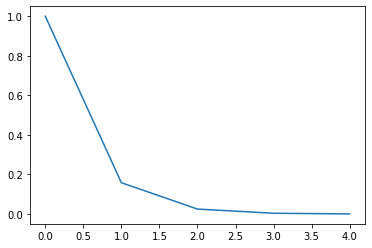

In [10]:
plt.plot(div_term.numpy())

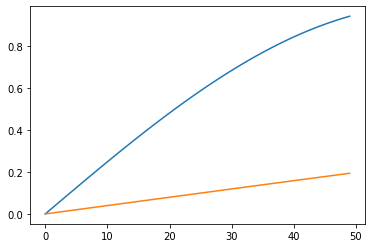

In [20]:
plt.plot(pe.numpy()[:, 4])
plt.plot(pe.numpy()[:, 6])

### Load and batch data